### Import libraries

In [1]:
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import nltk
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
cores = multiprocessing.cpu_count()
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import data

In [2]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [3]:
people_data = pd.read_csv('conflicting_comments.csv')

In [4]:
people_data['processed_body'] = people_data['processed_body'].astype(str)

In [5]:
compressed_data= pd.DataFrame(people_data.groupby(['author'])['processed_body'].apply(lambda x: '. '.join(x))).reset_index()

In [6]:
compressed_data.head()

,author,processed_body
0,--shaunoftheliving,pay testin opinionnials change anyone mind
1,-4,0.86
2,-bluewave-,mean really diffisee yoult call trump jewish p...
3,-dank-matter-,every tinstant messagee boston globe re-mailin...
4,1994spaceodyssey,mandate fail policy experinstant messageent lo...


In [7]:
compressed_data_tagged = compressed_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['processed_body']), tags=[r.author]), axis=1)

### Train Doc2Vec

In [8]:
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(compressed_data_tagged.values)])

100%|██████████| 960/960 [00:00<00:00, 551353.12it/s]


In [9]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(compressed_data_tagged.values)]), total_examples=len(compressed_data_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 960/960 [00:00<00:00, 1360314.81it/s]


In [10]:
def vec_for_clustering(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [11]:
targets, learned_vectors = vec_for_clustering(model_dbow, compressed_data_tagged)

In [12]:
vectored_data = pd.concat([pd.DataFrame({'author': targets}), pd.DataFrame(learned_vectors)], axis = 1)

### Train K-Means

In [13]:
# train a kmeans on n clusters = 2
km = KMeans(n_clusters=2).fit(vectored_data.loc[:, vectored_data.columns != 'author'])
vectored_data['cluster'] = km.predict(vectored_data.loc[:, vectored_data.columns != 'author'])

### Use t-SNE for plotting

In [14]:
# tsne for dimensionality reduction
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(vectored_data.loc[:, vectored_data.columns != 'author'])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 960 samples in 0.005s...
[t-SNE] Computed neighbors for 960 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 0.136133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.595955
[t-SNE] KL divergence after 4250 iterations: 0.852555
t-SNE done! Time elapsed: 27.986763954162598 seconds


In [15]:
# save to original dataframe
vectored_data['x_tsne'] = tsne_results[:,0]
vectored_data['y_tsne'] = tsne_results[:,1]

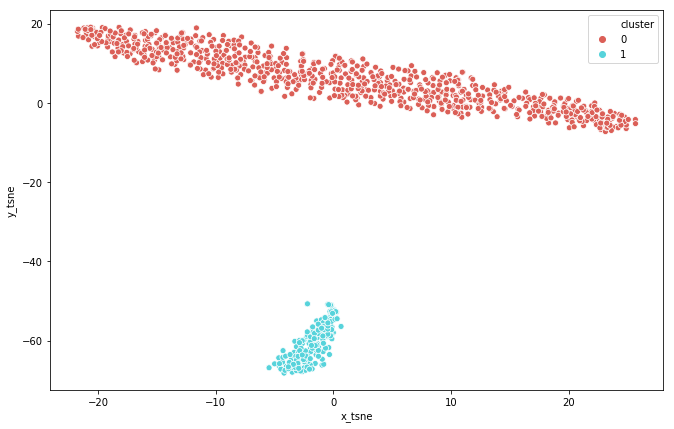

In [16]:
plt.figure(figsize=(11,7))
sns.scatterplot(x = 'x_tsne', y = 'y_tsne', data = vectored_data, hue = 'cluster', palette=sns.color_palette("hls", 2))
plt.show()

### Compare with Rule Based Classification

In [17]:
original_group = people_data.groupby(['author', 'comment_group'], as_index=False).first()[['author', 'comment_group']]

In [18]:
rem_authors = original_group.loc[(original_group['comment_group'] == original_group['comment_group'].value_counts().index[2]) |
                   (original_group['comment_group'] == original_group['comment_group'].value_counts().index[3])]['author'].values

In [19]:
vectored_data = vectored_data.loc[~vectored_data.author.isin(rem_authors), :]
original_group = original_group.loc[~original_group.author.isin(rem_authors), :]

In [20]:
combined_data = pd.merge(left=vectored_data[['author', 'cluster']], right = original_group) 

In [21]:
combined_data.groupby(['cluster', 'comment_group']).agg('count')

author
cluster comment_group        
0       Republican        270
        democrats         504
1       Republican         65
        democrats         119

In [30]:
combined_data.rename(columns={"comment_group": "rule_based", "cluster": "ml_based"})
combined_data['link'] = 'https://www.reddit.com/u/'+ combined_data['author']
combined_data.to_csv('./user_groups_predicted_plus_rule.csv', header= False)